# LSDB Commisioning Project 4: Find RRLyrae variables in ComCam data

## Installation

In [2]:
%pip install lsdb astropy light_curve --quiet

Note: you may need to restart the kernel to use updated packages.


In [1]:
import lsdb
lsdb.__version__

'0.4.4'

In [1]:
# Relevant Directories
#ls /sdf/scratch/users/n/ncaplar/HATS

comcam_obj = "/sdf/data/rubin/shared/lsdb_commissioning/Object_50"
comcam_src = "/sdf/data/rubin/shared/lsdb_commissioning/forcedSource_50"
comcam_diasrc = "/sdf/data/rubin/shared/lsdb_commissioning/diaSource_50"
comcam_srcmjd = "/sdf/data/rubin/shared/lsdb_commissioning/forcedSource_50_with_mjd"

## Loading ComCam Data into LSDB

In [2]:
from dask.distributed import Client

# Start with a small client
client = Client(n_workers=24, memory_limit="3GB", threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 24
Total threads: 24,Total memory: 67.06 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:14005,Workers: 24
Dashboard: http://127.0.0.1:8787/status,Total threads: 24
Started: Just now,Total memory: 67.06 GiB
Comm: tcp://127.0.0.1:5701,Total threads: 1
Dashboard: http://127.0.0.1:14231/status,Memory: 2.79 GiB
Nanny: tcp://127.0.0.1:3807,


In [3]:
# Initial loading

from lsdb import read_hats


#obj_hats = read_hats(comcam_obj)
src_hats = read_hats(comcam_src, columns=["objectId", "coord_ra", "coord_dec", "band", "psfFlux", "psfFluxErr", "visit"])

src_hats


,objectId,coord_ra,coord_dec,band,psfFlux,psfFluxErr,visit
npartitions=310,,,,,,,
"Order: 5, Pixel: 32",int64[pyarrow],double[pyarrow],double[pyarrow],string[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow]
"Order: 7, Pixel: 544",...,...,...,...,...,...,...
...,...,...,...,...,...,...,...
"Order: 6, Pixel: 35971",...,...,...,...,...,...,...
"Order: 2, Pixel: 141",...,...,...,...,...,...,...


## Dealing with missing MJD Information

In [24]:
# diasources have mjds tied to visits
from lsdb import read_hats
visit_mjds = read_hats(comcam_diasrc, columns=["visit", "midpointMjdTai"])
visit_lookup = visit_mjds._ddf.set_index("visit").drop_duplicates() # create a visit/mjd lookup table
visit_lookup.head(5)

,midpointMjdTai
visit,
2024110500210,60620.30587
2024110500230,60620.317381
2024110500247,60620.32962
2024110600158,60621.18728
2024110600164,60621.190339


In [5]:
# Generate a Forced Source Table with MJDs

# Index Forced Sources on and join to the visit lookup table
src_ddf = src_hats._ddf.set_index("visit")
src_mjd_ddf = src_ddf.join(visit_lookup)

# Reindex on objectId and save to parquet (this is no longer HATS)
src_mjd_ddf = src_mjd_ddf.set_index("objectId")
#src_mjd_ddf.to_parquet("/sdf/data/rubin/shared/lsdb_commissioning/forcedSource_50_with_mjd") # uncomment to save to disk

## Loading & Nesting Forced Sources

In [3]:
# Load the Forced Source + MJD Table
import nested_dask as nd

src_mjd_ddf = nd.read_parquet("/sdf/data/rubin/shared/lsdb_commissioning/forcedSource_50_with_mjd", calculate_divisions=True)
src_nested = nd.NestedFrame.from_flat(src_mjd_ddf, base_columns=["coord_ra", "coord_dec"],
                                      nested_columns=["band", "psfFlux", "psfFluxErr", "midpointMjdTai"],
                                      name="lc")
src_nested


,coord_ra,coord_dec,lc
npartitions=310,,,
199279885464633345,double[pyarrow],double[pyarrow],"nested<band: [large_string], psfFlux: [double], psfFluxErr: [double], midpointMjdTai: [double]>"
199548166301815239,...,...,...
...,...,...,...
4708143974508930760,...,...,...
4708236333485657710,...,...,...


In [4]:
# Grab columns from the Object Catalog
from lsdb import read_hats
obj_ddf = read_hats(comcam_obj, columns=["objectId", "g_psfFlux", "r_psfFlux"])._ddf.set_index("objectId")

# LSDB joins with non-catalogs don't really work, so cheating by using native Dask/Nested-Dask
src_nested = src_nested.join(obj_ddf).dropna(subset=["g_psfFlux", "r_psfFlux"])
src_nested

,coord_ra,coord_dec,lc,g_psfFlux,r_psfFlux
npartitions=393,,,,,
199279885464633345,double[pyarrow],double[pyarrow],"nested<band: [large_string], psfFlux: [double], psfFluxErr: [double], midpointMjdTai: [double]>",double[pyarrow],double[pyarrow]
199389836627411188,...,...,...,...,...
...,...,...,...,...,...
4708143974508930760,...,...,...,...,...
4708236333485657710,...,...,...,...,...


In [5]:
# Pre-Processing

# Use just r-band data
src_nested = src_nested.query("lc.band == 'r'").dropna(subset="lc")

# Remove any high-error measurements
src_nested = src_nested.query("lc.psfFluxErr < 500").dropna(subset="lc")

# Count the length of the lightcurves, and add a length filter
from nested_dask.utils import count_nested
src_nested = count_nested(src_nested, "lc", join=True).query("n_lc > 200")

In [6]:
# g-r cut (proxy for B-V)
import astropy.units as u
import numpy as np

# Define a g_r calculation function
def g_r(g_flux, r_flux):
    """calculates g-r from g_flux and r_flux"""
    g_mag = u.nJy.to(u.ABmag, g_flux)
    r_mag = u.nJy.to(u.ABmag, r_flux)
    return {"gr": g_mag-r_mag}

# Apply the function, and return as a new column
src_nested = src_nested.query("g_psfFlux > 0 and r_psfFlux > 0")
g_r = src_nested.reduce(g_r, "g_psfFlux", "r_psfFlux", meta={"gr": np.float32})
src_nested = src_nested.join(g_r)

# Then cut on g-r
src_nested = src_nested.query("gr > -0.1 and gr < 0.5")
src_nested

,coord_ra,coord_dec,lc,g_psfFlux,r_psfFlux,n_lc,gr
npartitions=393,,,,,,,
199279885464633345,double[pyarrow],double[pyarrow],"nested<band: [large_string], psfFlux: [double], psfFluxErr: [double], midpointMjdTai: [double]>",double[pyarrow],double[pyarrow],float64,float32
199389836627411188,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...
4708143974508930760,...,...,...,...,...,...,...
4708236333485657710,...,...,...,...,...,...,...


In [21]:
len(src_nested) # number of lightcurves after the above cuts

30534

## Running Lomb-Scargle
Use Lightcurve package

In [7]:
import light_curve as licu
import numpy as np

extractor = licu.Extractor(
    licu.Periodogram(
        peaks=1,
        #nyquist=0.5, # this seems to hang the run
        max_freq_factor=30, # Currently 1.0 for fast runs, will raise for more interesting graphs later
        fast=False,
    ),  # Would give two features: peak period and signa-to-noise ratio of the peak
)


# light-curve requires all arrays to be the same dtype.
# It also requires the time array to be ordered and to have no duplicates.
def extract_features(mjd, mag, **kwargs):
    # We offset date, so we still would have <1 second precision
    t = np.asarray(mjd - 60000, dtype=np.float64)

    # Filter any infinite mags (fluxes here)
    t = t[np.isfinite(mag)]
    mag = mag[np.isfinite(mag)]

    _, sort_index = np.unique(t, return_index=True)
    features = extractor(
        t[sort_index],
        mag[sort_index],
        **kwargs,
    )
    # Return the features as a dictionary
    return dict(zip(extractor.names, features))


features = src_nested.reduce(
    extract_features,
    "lc.midpointMjdTai",
    "lc.psfFlux",
    meta={name: np.float32 for name in extractor.names},
)

src_nested = src_nested.join(features)

In [23]:
src_nested.head(5, npartitions=-1)

,coord_ra,coord_dec,lc,g_psfFlux,r_psfFlux,n_lc,gr,period_0,period_s_to_n_0
objectId,,,,,,,,,
2132568772769219544,53.028352,-28.307962,band psfFlux psfFluxErr midpointMjdT...,239.065489,363.600509,201,0.455269,0.020909,8.404782
2132568772769219727,53.03881,-28.30068,band psfFlux psfFluxErr midpointMjdT...,112.579908,119.026103,201,0.060453,0.019996,7.262893
2132568772769219768,53.063539,-28.298963,band psfFlux psfFluxErr midpointMjdT...,91.710765,85.149336,202,-0.080598,0.015688,8.522769
2132568772769219866,53.064233,-28.294273,band psfFlux psfFluxErr midpointMjd...,592.610002,727.641239,202,0.222871,0.019690,8.593285
2132568772769219920,53.064821,-28.292499,band psfFlux psfFluxErr midpointMjdT...,177.399504,178.411368,202,0.006175,0.069963,7.436450


## RRLyrae Candidate Selection
* Have periods of ~0.3–0.6 days

In [8]:
%%time
# Look for periods around half a day, select for high S/N
src_nested_rrcand = src_nested.query("period_0 > 0.3 and period_0 < 0.6").query("period_s_to_n_0 > 10")


CPU times: user 10.2 ms, sys: 3.58 ms, total: 13.8 ms
Wall time: 13.1 ms


In [25]:
len(src_nested_rrcand)

17

## Plotting a few Phase-Folded Candidates

In [9]:
cand_subset = src_nested_rrcand.head(1000, npartitions=-1)
cand_subset = cand_subset.sort_values(by="period_s_to_n_0", ascending=False)

In [10]:
cand_subset

,coord_ra,coord_dec,lc,g_psfFlux,r_psfFlux,n_lc,gr,period_0,period_s_to_n_0
objectId,,,,,,,,,
2133039363745925051,53.252511,-28.186259,band psfFlux psfFluxErr midpointMjd...,450.61279,538.127402,207,0.192704,0.333295,12.683511
2226748540758018644,53.243931,-28.191208,band psfFlux psfFluxErr midpointMjd...,473.048957,565.581496,201,0.193973,0.332986,12.525687
2226796919269630761,52.987749,-28.195892,band psfFlux psfFluxErr midpointMjdT...,221.541191,248.93723,202,0.126588,0.332268,12.426941
2226792521223123861,53.099912,-28.114481,band psfFlux psfFluxErr midpointMjdT...,173.244471,195.768252,210,0.132707,0.304277,12.313243
2226796919269640418,53.090893,-28.019704,band psfFlux psfFluxErr midpointMjdT...,77.524048,97.190093,204,0.245464,0.499710,11.744122
2226796919269630778,52.990574,-28.196002,band psfFlux psfFluxErr midpointMjd...,166.874106,241.21828,208,0.400053,0.499663,11.583959
2133039363745925068,53.255037,-28.18484,band psfFlux psfFluxErr midpointMjdT...,169.345308,209.725269,204,0.232194,0.333318,11.506978
2226796919269630775,52.989952,-28.196357,band psfFlux psfFluxErr midpointMjd...,242.633376,308.182304,207,0.259643,0.333295,11.295020
2133039363745925055,53.253173,-28.185938,band psfFlux psfFluxErr midpointMjd...,255.804666,364.99154,208,0.385936,0.332930,10.839012


2226796919269630775


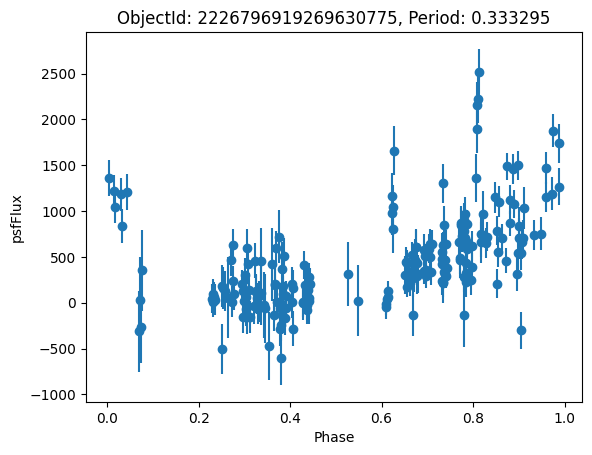

In [12]:
import matplotlib.pyplot as plt

#cand = cand_subset.iloc[1]
cand = cand_subset.loc[2226796919269630775]
phase = cand.lc["midpointMjdTai"] % cand["period_0"] / cand["period_0"]
plt.errorbar(phase,cand.lc["psfFlux"],cand.lc["psfFluxErr"], fmt="o")
plt.title(f"ObjectId: {cand.name}, Period: {np.round(cand['period_0'],6)}")
plt.ylabel("psfFlux")
plt.xlabel("Phase")
print(cand.name)

### Potentially Interesting Candidates
2226748540758018644, 2226840899734749849, 2226796919269630775